# Project: Build a Traffic Sign Recognition Classifier

This project uses the German traffic sign dataset to create a LeNet ConvNet model for predicting the traffic signs.

---
## Step 0: Load The Data

In [4]:
# Load pickled data
import pickle

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# Extract the features and labels from the training and test sets
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

[ 0  0  0 ..., 42 42 42]


---
## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


In [3]:
### Replace each question mark with the appropriate value.
import pandas as pd

# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
signnames_df = pd.read_csv('signnames.csv')
n_classes = len(signnames_df)

# Print out some basic stats
print("Number of training samples =", n_train)
print("Number of testing samples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training samples = 39209
Number of testing samples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). I created a grid here which displays all the 43 signs used in the data set in a 4x11 image grid. Each image displayed has the sign id next to **_'#'_** followed by the number of images of that type in **_'()'_**

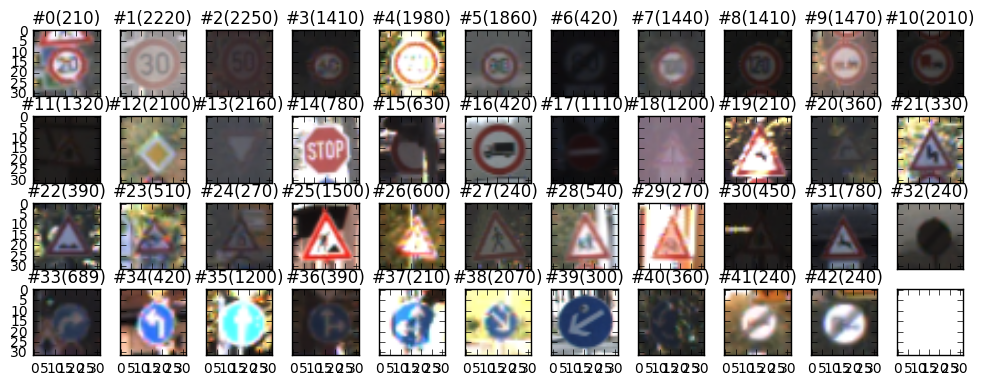

Length of the largest class =  2250


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

# Define the size of the figure
figure = plt.figure(figsize=(12, 12))
# A grid for displaying the images
grid = ImageGrid(figure, 111, nrows_ncols=(4, 11), axes_pad=0.2)

# Variable to store the length of the largest class
largest_class = 0

# Go through each sign ID and display one of the images associated with
# the sign ID from the training set
for sign_id in signnames_df['ClassId']:
    # np.where returns a tuple of arrays
    # first array points to the rows and the second array points to the columns
    # NOTE: y_train is a 1-D array
    image_index = np.where(y_train==sign_id)
    sign_image = X_train[image_index[0][0]]
    title = "#" + str(sign_id) + "(" + str(len(image_index[0])) + ")"
    grid[sign_id].imshow(sign_image)
    grid[sign_id].set_title(title)
    if(len(image_index[0]) > largest_class):
        largest_class = len(image_index[0])

plt.show()
print("Length of the largest class = ", largest_class)

---
## Step 2: Additional Data Generation
The section below generates additional training data to prevent bias and to make the model more robust. The test data set remains unchanged. Additional data is generated by randomly translating and rotating the images from a particular class, till a threshold is met. 

The algorithm is follows:

1. Go through each class, pick a random image from that class
2. Generate an image which will have a random rotation and translation
3. Check if the threshold of 2500 + (random slack between 1-20 is reached)
4. Pick the next random image from the same class if threshold is not reached
5. Go to next class if threshold is reached and generate additional images using steps 1-4

In [5]:
import random
import cv2

# DON'T change this to make sure the results don't vary 
random.seed(1000)

# Generate additional data to have a uniform distribution of classes to 
# prevent bias towards certain classes and to improve robustness of the model.
def transform_image(img, ang_range, trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    Code modified from: http://bit.ly/2iQKSUl, author Vivek Yadav
    '''
    # Rotation
    ang_rot = np.random.uniform(ang_range) - ang_range/2
    rows, cols, ch = img.shape    
    rot_M = cv2.getRotationMatrix2D((cols/2, rows/2), ang_rot, 1)

    # Translation
    tr_x = trans_range*np.random.uniform() - trans_range/2
    tr_y = trans_range*np.random.uniform() - trans_range/2
    trans_M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])
        
    img = cv2.warpAffine(img, rot_M, (cols,rows))
    img = cv2.warpAffine(img, trans_M, (cols,rows))
    
    return img

def generateAdditionalData(X_train_old, y_train_old):
    '''
    Takes the old training set and generates a set of new images.
    The images are then added to the list along with the associated class.
    '''
    # List to store additional images
    additional_train_list = []

    for sign_id in signnames_df['ClassId']:
        # Get a tuple of indices associated with this sign id from y_train array
        image_index_tuple = np.where(y_train_old==sign_id)

        # Generate a random threshold(2500-2520) for this sign id
        variable_max_threshold = random.randint(2500, 2520)

        # Get a count of the images of the type of this sign id
        image_count = len(image_index_tuple[0])

        # Generate tranformed images and add to a list
        while image_count < variable_max_threshold:
            # Get a random index associated with the Class Id
            random_index = random.randint(0, (len(image_index_tuple[0]) - 1 ))
            image_index = image_index_tuple[0][random_index]
            # Get the associated image from the index
            sign_image = X_train_old[image_index]
            # Apply a transform
            transformed_image = transform_image(sign_image, 20, 5)
            # Add the transformed image and it's class to the list
            additional_train_list.append([transformed_image, sign_id])
            # Increment image count
            image_count = image_count + 1
            
    return additional_train_list

def generateNewTrainingSet(X_train_old, y_train_old, additional_train_list):
    '''
    Takes the old training set and newly generated list and generates 
    a new training set
    '''
    # Create new training and validation sets
    new_train_dim = len(X_train_old) + len(additional_train_list)
    X_new_train = np.zeros([new_train_dim, X_train_old.shape[1], X_train_old.shape[2], X_train_old.shape[3]])
    y_new_train = np.zeros(new_train_dim)
    # Copy the original training data into a new set
    X_new_train[0:len(X_train_old), :, :, :] = X_train_old
    y_new_train[0:len(y_train_old),] = y_train_old
    y_new_train = y_new_train.astype(int)

    additional_train_list_index = 0

    for new_train_index in range(len(X_train_old), (len(X_new_train) - 1)):
        X_new_train[new_train_index] = additional_train_list[additional_train_list_index][0]
        y_new_train[new_train_index] = additional_train_list[additional_train_list_index][1]
        additional_train_list_index += 1

    return X_new_train, y_new_train

# Generate additional data
additional_train_list = generateAdditionalData(X_train, y_train)

# Generate new training set
X_new_train, y_new_train = generateNewTrainingSet(X_train, y_train, additional_train_list)

from sklearn.model_selection import train_test_split
# Split into training and validation sets
X_new_train, X_new_validation, y_new_train, y_new_validation = train_test_split(X_new_train, y_new_train, test_size=0.2, random_state=41)

# Print out the shape of the new data
print("Number of new training samples =", len(X_new_train))
print("Number of new validation samples =", len(X_new_validation))

Number of new training samples = 86281
Number of new validation samples = 21571


----

## Step 3: Design and Test a Model Architecture

Designed and implemented a deep learning model that learns to recognize traffic signs. Trained and tested the model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

In [6]:
### Preprocess the data here.
import cv2
from sklearn.preprocessing import MinMaxScaler

def grayscaleImages(imageSet):
    '''
    Applies gray scaling on the images
    '''
    imageSet_gray = np.zeros([imageSet.shape[0], imageSet.shape[1], imageSet.shape[2]])

    for image_index in range(0, len(imageSet)):
        imageSet_gray[image_index] = cv2.cvtColor(imageSet[image_index].astype(np.uint8), cv2.COLOR_RGB2GRAY)
    
    return imageSet_gray

def normalizeImages(imageSet):
    '''
    Normalizes the images within the range of 0.1-1.9
    '''
    min_max_scaler = MinMaxScaler(feature_range=(0.1, 0.9))
    
    for image_index in range(0, len(imageSet)):
        imageSet[image_index] = min_max_scaler.fit_transform(imageSet[image_index])
    
    return imageSet

# Convert the new training, validation and old test set to gray scale
X_train = grayscaleImages(X_new_train)
X_validation = grayscaleImages(X_new_validation)
X_test = grayscaleImages(X_test)

# Normalize the sets
X_train = normalizeImages(X_train)
X_validation = normalizeImages(X_validation)
X_test = normalizeImages(X_test)

# Need to reshape it for it to be acceptable as input to LeNet algorithm which is in the form
# 32x32xC(where C is the number of channels which in this case 1)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_validation = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

# New labels for training and validation
y_train = y_new_train
y_validation = y_new_validation

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
After reading through the paper by [Pierre Sermanet and Yann LeCun] one of the points which really stood out was how they accuracy increased when the images were converted to gray scale. ConvNets are designed to be color invariant but models generally seem to do better when color variability is removed. Another thing we learned in our lectures is how normalization of input values reduces bias(zero mean, unit variance) so I applied normalization to all the sets being used(training, validation and testing)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
I used the original training set to generate additional data(Step 2). The additional data(new training set) is different from the initial training data because it has some jitter in terms of translation and rotation. The new training set is then split into training and validation sets(80%-20%). The original test set was unchanged. 

In [7]:
### Define your architecture here.
import tensorflow as tf

EPOCHS = 20
BATCH_SIZE = 128

from tensorflow.contrib.layers import flatten

# LeNet model for German traffic dataset
def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.2
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x10.
    W_conv1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 10), mean = mu, stddev = sigma))
    b_conv1 = tf.Variable(tf.zeros(10))
    conv1   = tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='VALID') + b_conv1

    # Activation.
    conv1 = tf.nn.elu(conv1)

    # Pooling. Input = 28x28x10. Output = 14x14x10.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x30.
    W_conv2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 10, 30), mean = mu, stddev = sigma))
    b_conv2 = tf.Variable(tf.zeros(30))
    conv2   = tf.nn.conv2d(conv1, W_conv2, strides=[1, 1, 1, 1], padding='VALID') + b_conv2
    
    # Activation.
    conv2 = tf.nn.elu(conv2)

    # Pooling. Input = 10x10x30. Output = 5x5x30.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x30. Output = 750.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 750. Output = 450.
    W_fc1 = tf.Variable(tf.truncated_normal(shape=(750, 450), mean = mu, stddev = sigma))
    b_fc1 = tf.Variable(tf.zeros(450))
    fc1   = tf.matmul(fc0, W_fc1) + b_fc1
    
    # Activation.
    fc1    = tf.nn.elu(fc1)

    # Layer 4: Fully Connected. Input = 450. Output = 150.
    W_fc2  = tf.Variable(tf.truncated_normal(shape=(450, 150), mean = mu, stddev = sigma))
    b_fc2  = tf.Variable(tf.zeros(150))
    fc2    = tf.matmul(fc1, W_fc2) + b_fc2
    
    # Activation.
    fc2    = tf.nn.elu(fc2)

    # Layer 5: Fully Connected. Input = 150. Output = 43.
    W_fc3  = tf.Variable(tf.truncated_normal(shape=(150, 43), mean = mu, stddev = sigma))
    b_fc3  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, W_fc3) + b_fc3
    
    return logits

# Placeholders for training in batches
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
# One hot encoding 
one_hot_y = tf.one_hot(y, 43)

rate = 0.001

# Softmax, cross entropy, optimizer, learning rate
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Accuracy of predictions
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Object of type Saver to save and load model
model_saver = tf.train.Saver()

# Evalutaion
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** 
Although I would have loved to have implemented the model with the best accuracy described by [Pierre Sermanet and Yann LeCun] in their paper, I decided to stick with the LeNet model which was used in the LeNet lab for predicting handwritten numbers. LeNet made sense to me because although the original model was used for predicting numbers, the architecture seemed sound enough for predicting traffic signs as well.

LeNet has the following architecture:
1. 2 layers of convolutions + pooling, with valid padding
2. 2 fully connected layers
3. Output of the final layer used for prediction

Original LeNet model expects inputs in the form 32x32xC, where C is the number of channels. Here is an image of the architecture:
![](https://shadowthink.com/images/dl/LeNet.png?raw=true)

I modified the architecture by playing around with the number of filters in the first two stages and the number of inputs and outputs to/from the fully connected layers. The final configuration which gave me the best accuracy:
1. 10 filters in the 1st stage(convolution + pooling)
2. 30 filters in the 2nd stage(convolution + pooling)
3. 750 inputs to the 1st fully connected layer producing 450 outputs
4. 450 outputs to the 2nd fully connected layer producing 150 outputs
5. Last layer using the 150 inputs to make predictions(logits)of size 43(number of classes)

Another modification to the LeNet model from the Lab was to use Exponential Linear Units(ELUs) instead of Rectified Linear Units. The paper from [Pierre Sermanet and Yann LeCun] mentioned about how recent advancements in activation functions have shown to improve accuracy and speeds with respect to learning. So I researched recent activation functions and picked ELUs as the activation function(https://arxiv.org/abs/1511.07289) because the creators claim that the speed of networks improves when using ELUs for activation along with improved accuracy of the network. 

In [9]:
from sklearn.utils import shuffle
### Train your model here.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    # NOTE: Once the saver object is defined it can be used to save (or restore).
    # On a fresh session this might fail
    model_saver.save(sess, 'lenet1')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.763

EPOCH 2 ...
Validation Accuracy = 0.888

EPOCH 3 ...
Validation Accuracy = 0.928

EPOCH 4 ...
Validation Accuracy = 0.940

EPOCH 5 ...
Validation Accuracy = 0.951

EPOCH 6 ...
Validation Accuracy = 0.960

EPOCH 7 ...
Validation Accuracy = 0.959

EPOCH 8 ...
Validation Accuracy = 0.948

EPOCH 9 ...
Validation Accuracy = 0.965

EPOCH 10 ...
Validation Accuracy = 0.966

EPOCH 11 ...
Validation Accuracy = 0.969

EPOCH 12 ...
Validation Accuracy = 0.963

EPOCH 13 ...
Validation Accuracy = 0.971

EPOCH 14 ...
Validation Accuracy = 0.972

EPOCH 15 ...
Validation Accuracy = 0.969

EPOCH 16 ...
Validation Accuracy = 0.976

EPOCH 17 ...
Validation Accuracy = 0.973

EPOCH 18 ...
Validation Accuracy = 0.978

EPOCH 19 ...
Validation Accuracy = 0.977

EPOCH 20 ...
Validation Accuracy = 0.979

Model saved


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_

**Answer:**
1. Optimizer: Decided to stick with Adam optimizer as it is a better version of SGD.
2. Batch Size: A batch size of 128 among the set [128, 150, 200, 256] showed the best accuracy when training the model. 
3. Epochs: 20, I played around with ranges from 10-20 but 20 gave the highest accuracy. 
4. Hyperparameters: A mean and standard deviation of (0, 0.2) for weights and biases vs (0, 0.1) definitely showed a better accuracy of the model. Anything above 0.25 showed a significant drop in accuracy. The learning rate was set to 0.001. I did limit the normalization scaling to 0.1(min)-0.9(max)

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
I decided to modify the LeNet ConvNet because it was proved to have high accuracy on the MNIST dataset which had 10 classes. The approach to the problem of determining the class of an image object, via layers of recognition(lines/edges->advanced shapes->symbol recognition) through a ConvNet like LeNet made it an obvious first choice for a beginner like me to implement and test on the German Traffic Sign dataset. 

In [10]:
# Test the model
with tf.Session() as sess:
    model_saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.930


---

## Step 4: Test a Model on New Images

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
I decided to use the test set from(http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset) for creating 5 additional images. I scanned through the images from the test set, picked 5 images, cropped them to 160x160(width, height) and converted them to .png format(because the originals were in .ppm). I cropped the images with the following thought process(going in the order of images displayed in the code cell below):

1.  **_Sign ID #38:_** This image had the sign above a reflector sign, I wanted to see how the model would react when the sign is not the only object in focus

2. **_Sign ID #7:_** This image had the sign in focus, assumption here was the model would easily detect the sign in the image

3. **_Sign ID #32:_**  Picked this one because the sign was completely in the dark in the image, again wanted to see if the model would detect the sign

4. **_Sign ID #30 & #17:_** These images had the signs in two corners, the aim was to see how good the model is with it's translational invariance.

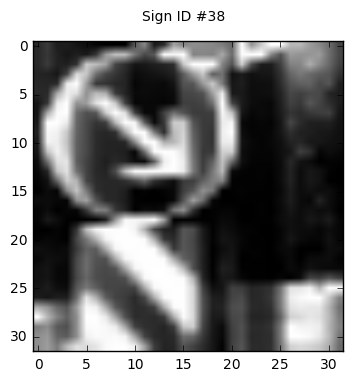

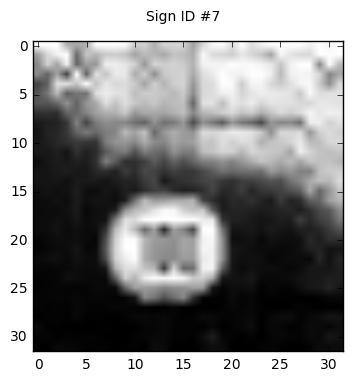

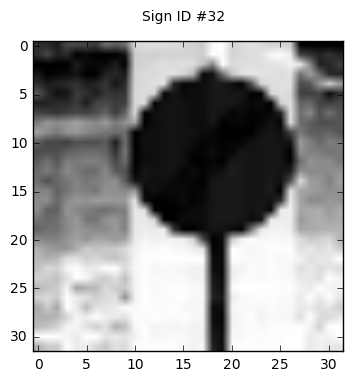

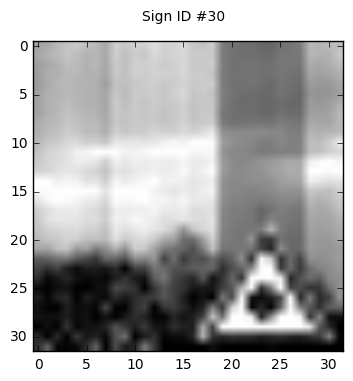

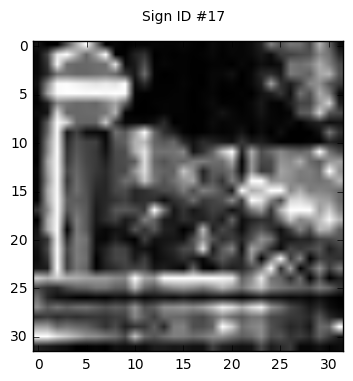

In [11]:
import cv2
import os

def createNewTestSet():
    '''
    Create a new test set to test the new images
    '''
    # Empty new test set shaped like the test set used above
    # NOTE: This returns color images, needs to be converted to gray scale
    X_new_test = np.zeros([5, 32, 32, 3])
    
    # Empty new test labels(5 rows, one column)
    y_new_test = np.zeros(5)
    
    index = 0
    # Get the current working directory
    cwd = os.getcwd()
    for file in os.listdir(cwd):
        if file.endswith(".png"):
            # Read the image and resize the image
            image = cv2.imread(file)
            image = cv2.resize(image, (32, 32))
            
            # OpenCV reads images in the BGR format, convert them into RGB
            image_rgb =  cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            X_new_test[index] = image_rgb
            
            if(file == "image1.png"):
                # 7, Speed limit (100km/h)
                y_new_test[index] = 7
            elif(file == "image2.png"):
                # 30, Beware of ice/snow
                y_new_test[index] = 30
            elif(file == "image3.png"):
                # 38,Keep right
                y_new_test[index] = 38
            elif(file == "image4.png"):
                # 32,End of all speed and passing limits
                y_new_test[index] = 32
            elif(file == "image5.png"):
                # 17,No entry
                y_new_test[index] = 17
            
            # Increment index
            index = index + 1
                
    return X_new_test, y_new_test

def displayNewTestImages(X_new_test, y_new_test):
    '''
    Function to display the new images
    '''
    for index in range(0, len(X_new_test)):    
        image = X_new_test[index].squeeze()
        figure = plt.figure(figsize=(4,4))
        figure.suptitle("Sign ID #" + str(y_new_test[index]))
        plt.imshow(image, cmap="gray")
            
# Create new test set and labels
X_new_test, y_new_test = createNewTestSet()

# Convert into gray scale 
X_new_test = grayscaleImages(X_new_test)

# Convert to integer
y_new_test = y_new_test.astype(int)

# Normalize the set
X_new_test = normalizeImages(X_new_test)

# Display the images in gray scale
displayNewTestImages(X_new_test, y_new_test)

# Reshape for LeNet
X_new_test = np.reshape(X_new_test, (X_new_test.shape[0], X_new_test.shape[1], X_new_test.shape[2], 1))

In [12]:
# Run the model on the new test set
with tf.Session() as sess:
    model_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    test_accuracy = sess.run(accuracy_operation, feed_dict={x: X_new_test, y: y_new_test})
    print("Test Accuracy on new set = {:.3f}".format(test_accuracy))

Test Accuracy on new set = 0.000


### Question 7

Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate.

**Answer:**
The accuracy on the test set I created turned out to be 0.000, the results made sense for images with the Sign IDs #38, #32 because they seemed like they belonged "hard to classify" category. I was definitely surprised as to why images with the Sign IDs #7, #30 & #17 were not detected. One of the factors might be that the model was trained and validated with images which had the sign completely in focus(even with additional data of translated and rotated training images). But the images which were created by me looked like they didn't quite meet the model requirements and were not classified accurately when compared to the ones in test set(~92-93% predicted accurately). 

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

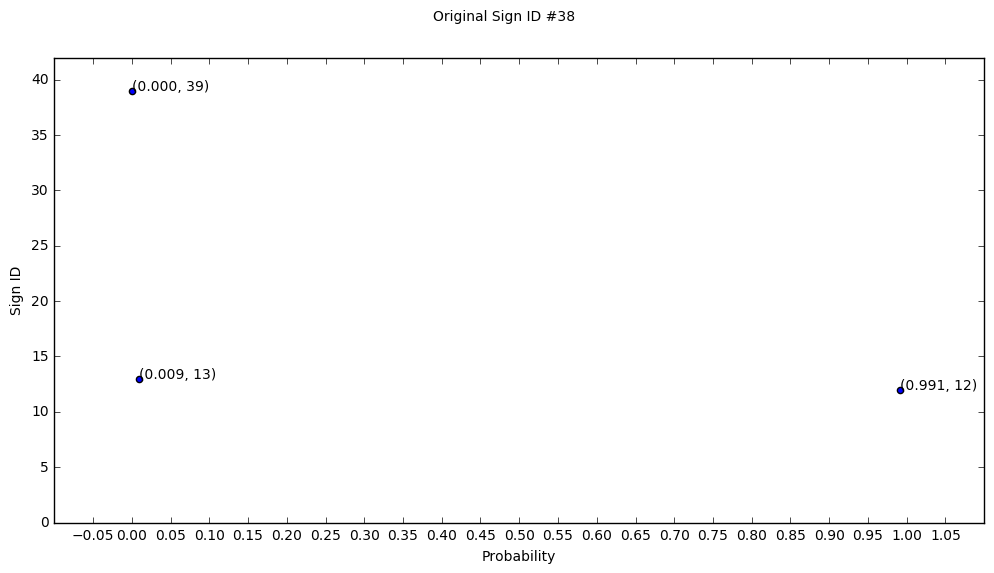

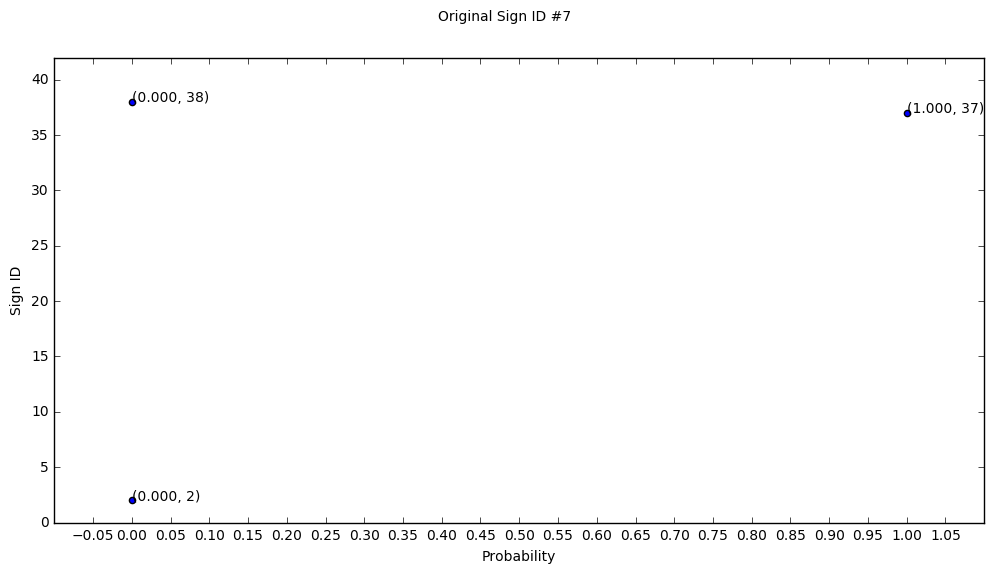

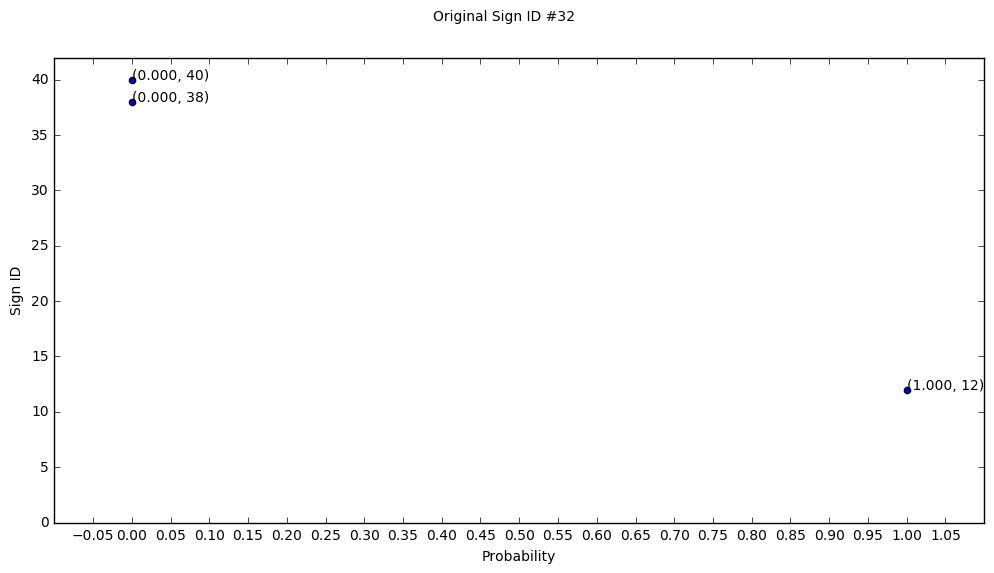

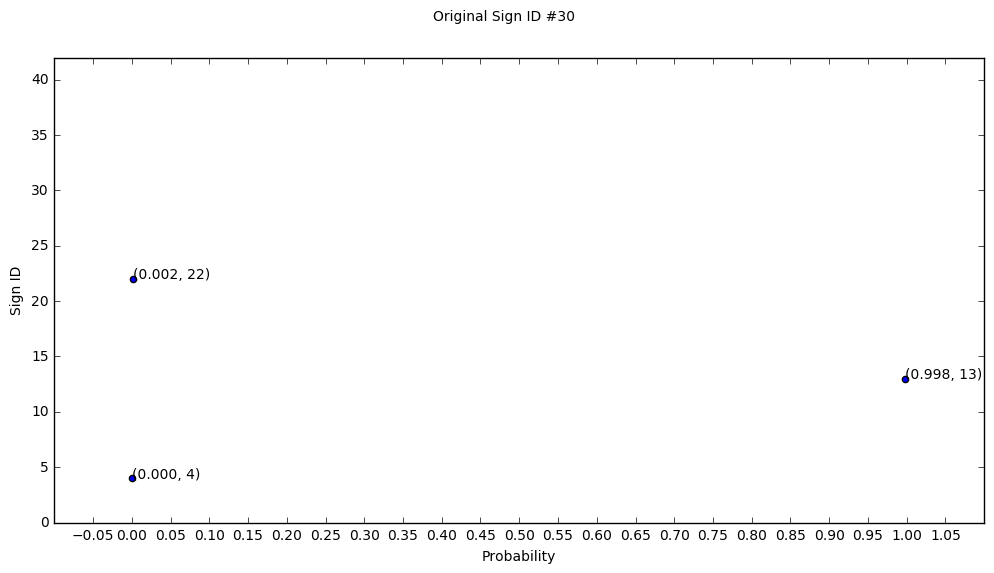

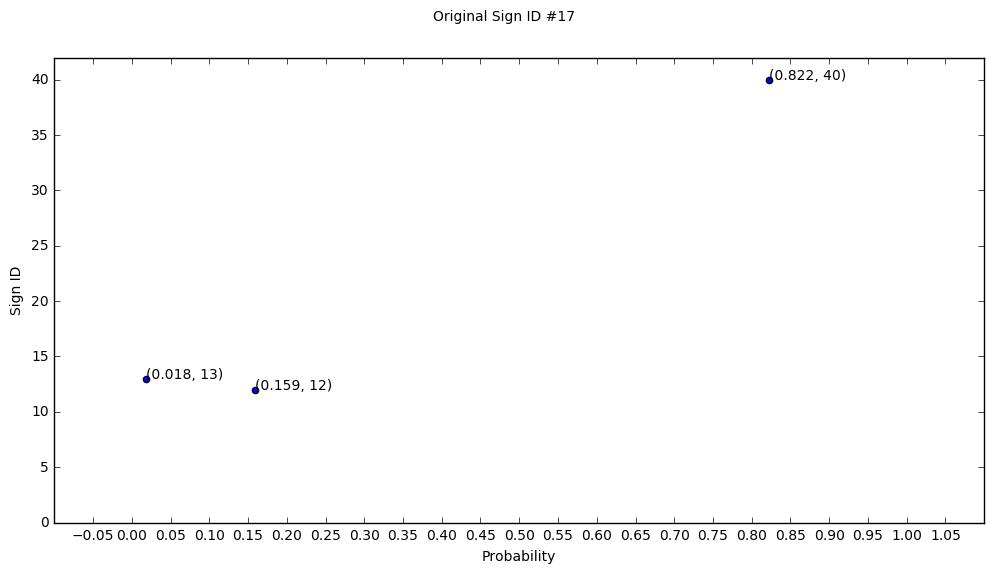

In [13]:
# Logits is the output from the LeNet CNN
softmax = tf.nn.softmax(logits)
# tf.nn.top_k returns the largest 'k' values and it's corresponding indices(class ids)
k_top = tf.nn.top_k(softmax, k=3)

with tf.Session() as sess:
    model_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    # Run the session with new test data
    output_softmax = sess.run(k_top, feed_dict={x: X_new_test})

import matplotlib.pyplot as plt

# Output is a tuple of 2 arrays
probabilities = output_softmax[0]
class_ids = output_softmax[1]

# Ticks for X-axis
x_ticks = [-0.05, 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5,
           0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05]

# Create a scatter plot of probability and sign id with the title of each plot
# being the sign ID in the image being predicted
for row in range(0, probabilities.shape[0]):
    X = probabilities[row]
    Y = class_ids[row]
    plt.figure(figsize=(12, 6))
    plt.scatter(X, Y)
    plt.xlim(-0.1, 1.1)
    plt.ylim(0, 42)
    plt.xticks(x_ticks)
    plt.xlabel('Probability')
    plt.ylabel('Sign ID')
    for point_index in range(0, len(X)):
        txt = "(" + str("%.3f" % X[point_index]) + ", " + str(Y[point_index]) + ")"
        plt.annotate(txt, (X[point_index], Y[point_index]))
        plt.suptitle("Original Sign ID #" + str(y_new_test[row]))
    plt.show()

**Answer:** 
The visualizations show the predicted output(class with highest probability) vs the actual output(header of the plot). The model is definitely certain of the predictions because the probabilities(big and small) are wide apart. But the sign id predicted ouput(the class associated with highest probability) was incorrect when compared to the actual output. 